# Data loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pickle

os.chdir("/content/drive/MyDrive/Reconocimiento de Patrones")

with open('preprocessed_data.pickle', 'rb') as file:
    filt_dict = pickle.load(file)
    segm_dict = pickle.load(file)
    norm_segm_dict = pickle.load(file)

Mounted at /content/drive


# Segmentación | Extracción de media y desviación estándar

In [2]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Calcula la longitud de todas las secuencias
lengths = [len(seq) for seq in norm_segm_dict['ABP']]  # Asumiendo ABP como referencia; también puedes combinar las longitudes de CBFV y ICP si es necesario

# Usa el percentil 95 para determinar max_len
max_len = int(np.percentile(lengths, 95))

print("Longitud de padding seleccionada:", max_len)

# Asumiendo que has calculado max_len como se indicó antes
norm_segm_dict['ABP'] = pad_sequences(norm_segm_dict['ABP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['CBFV'] = pad_sequences(norm_segm_dict['CBFV'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['ICP'] = pad_sequences(norm_segm_dict['ICP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')

Longitud de padding seleccionada: 122


In [3]:
# Calcular media
cbfv_means = np.array([np.mean(seq) for seq in segm_dict['CBFV']])
abp_means = np.array([np.mean(seq) for seq in segm_dict['ABP']])
icp_means = np.array([np.mean(seq) for seq in segm_dict['ICP']])

# Calcular std
cbfv_std = np.array([np.std(seq) for seq in segm_dict['CBFV']])
abp_std = np.array([np.std(seq) for seq in segm_dict['ABP']])
icp_std = np.array([np.std(seq) for seq in segm_dict['ICP']])

# Crear la matriz de características combinando medias y desviaciones estándar de ABP y CBFV
X_2 = np.column_stack((abp_means, abp_std, cbfv_means, cbfv_std))

# Crear la matriz de etiquetas con medias y desviaciones estándar de ICP
y_2 = np.column_stack((icp_means, icp_std))

# LSTM for ICP waveform

In [4]:
from sklearn.model_selection import train_test_split

X = np.stack((norm_segm_dict['ABP'], norm_segm_dict['CBFV']), axis=-1)  # Forma: [num_samples, timesteps, num_channels]
y = norm_segm_dict['ICP']

y_or = segm_dict['ICP']

original_lengths = np.array([len(seq) for seq in y_or])

# Crear un arreglo de índices
indices = np.arange(len(X))

# Primero dividir en entrenamiento y prueba
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=110)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
indices_train, indices_val = train_test_split(indices_train, test_size=0.2, random_state=110)  # 0.25 x 0.8 = 0.2

# Usar estos índices para dividir tus datos originales y estadísticos
X_train, X_val, X_test = X[indices_train], X[indices_val], X[indices_test]
y_train, y_val, y_test = y[indices_train], y[indices_val], y[indices_test]

X_train2, X_val2, X_test2 = X_2[indices_train], X_2[indices_val], X_2[indices_test]
y_train2, y_val2, y_test2 = y_2[indices_train], y_2[indices_val], y_2[indices_test]

train_lengths, val_lengths, test_lengths = original_lengths[indices_train], original_lengths[indices_val], original_lengths[indices_test]

In [5]:
from keras.models import Sequential
from keras.losses import Huber
from keras.layers import LSTM, Dense
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import numpy as np

# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(122, 2)))
model.add(LSTM(50, return_sequences=True))
model.add(Dense(1))

# Definir la función de pérdida y el optimizador
optimizer = SGD(learning_rate=0.1, momentum=0.9)
loss = Huber(delta=1.0)  # Puede ser 'mae' o Huber()

model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])

# Implementar el learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[lr_scheduler])


Epoch 1/70
597/597 [==============================] - 18s 19ms/step - loss: 0.1278 - mse: 0.2810 - val_loss: 0.1141 - val_mse: 0.2498 - lr: 0.1000
Epoch 2/70
597/597 [==============================] - 13s 23ms/step - loss: 0.1031 - mse: 0.2264 - val_loss: 0.0997 - val_mse: 0.2177 - lr: 0.1000
Epoch 3/70
597/597 [==============================] - 14s 23ms/step - loss: 0.0919 - mse: 0.2028 - val_loss: 0.0875 - val_mse: 0.1911 - lr: 0.1000
Epoch 4/70
597/597 [==============================] - 11s 18ms/step - loss: 0.0841 - mse: 0.1857 - val_loss: 0.0797 - val_mse: 0.1751 - lr: 0.1000
Epoch 5/70
597/597 [==============================] - 9s 16ms/step - loss: 0.0773 - mse: 0.1707 - val_loss: 0.0730 - val_mse: 0.1595 - lr: 0.1000
Epoch 6/70
597/597 [==============================] - 11s 18ms/step - loss: 0.0727 - mse: 0.1602 - val_loss: 0.0739 - val_mse: 0.1622 - lr: 0.1000
Epoch 7/70
597/597 [==============================] - 11s 19ms/step - loss: 0.0663 - mse: 0.1456 - val_loss: 0.0619 - v

# Overfitting check before saving


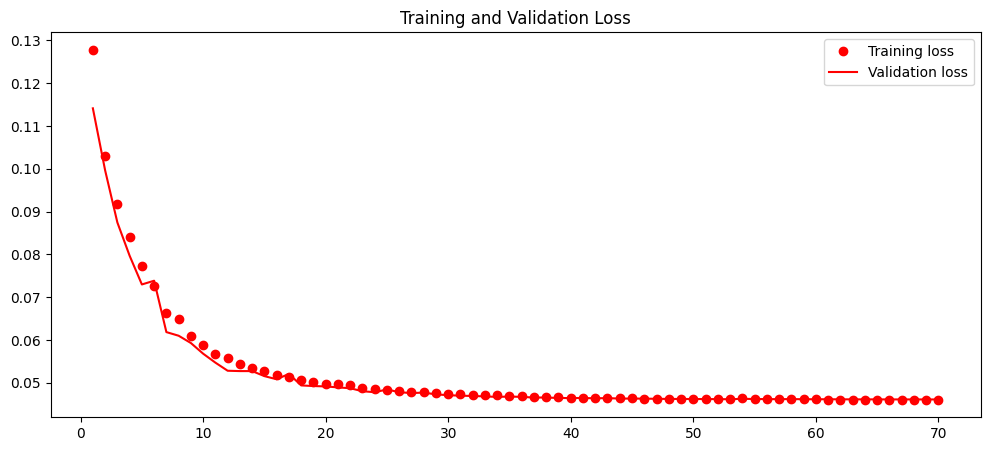

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 70 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [10]:
model.save('ModelosLSTM/model1b.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Pruebas Waveform

166/166 [==============================] - 4s 9ms/step


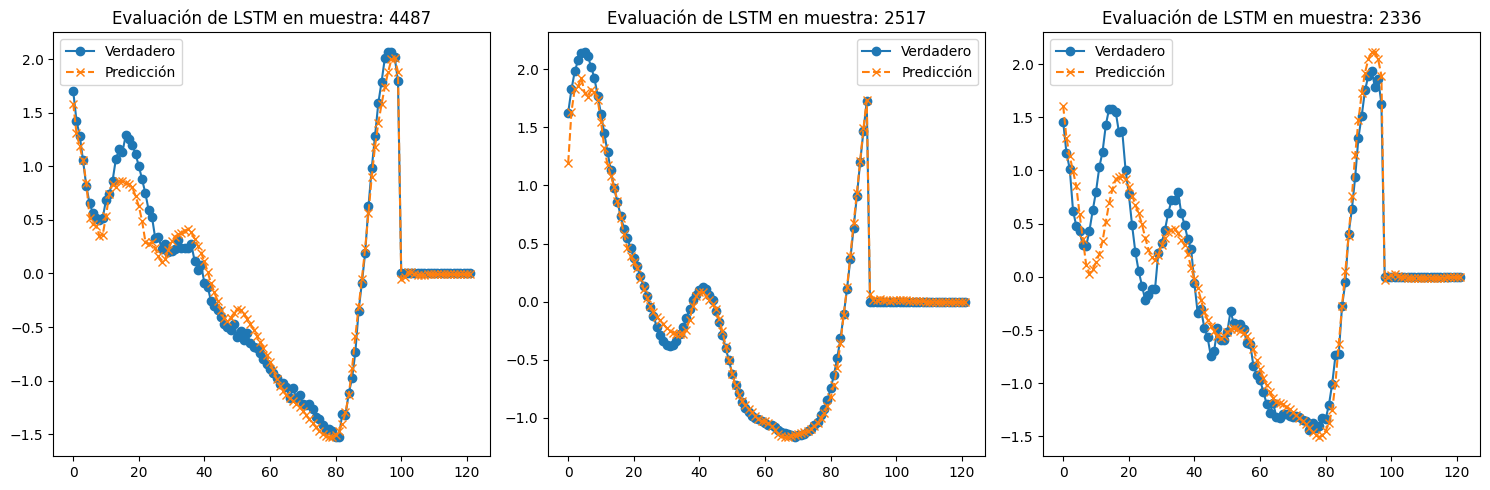

y_test shape: (5299, 122)
predictions shape: (5299, 122, 1)


In [12]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model.predict(X_test)
predictions_trimmed = [pred[:length] for pred, length in zip(predictions, test_lengths)]
y_test_trimmed = [pred[:length] for pred, length in zip(y_test, test_lengths)]

# Seleccionar 20 índices aleatorios para mostrar
num_examples = 3
indices = np.random.choice(len(predictions_trimmed), num_examples, replace=False)
indices = [4486, 2516, 2335]

# Configurar la figura para mostrar múltiples subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Ajusta el tamaño de la figura según necesidad
axes = axes.flatten()  # Aplanar el array de axes para una iteración más fácil

for idx, ax in zip(indices, axes):
    ax.plot(y_test[idx], label='Verdadero', marker='o', linestyle='-')
    ax.plot(predictions[idx], label='Predicción', marker='x', linestyle='--')
    ax.set_title(f'Evaluación de LSTM en muestra: {idx+1}')
    ax.legend()

# Ajustar el layout para evitar la superposición de subplots
plt.tight_layout()
plt.show()

# Imprimir las dimensiones para referencia
print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)